# Team 1 - Bike Sharing Code

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import dill

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

# Set number of CPU cores for parallel algorithms
import os
if "CPU_LIMIT" in os.environ:
    # If you are on JupyterHub, this gives you the right number of CPUs for your virtual machine
    num_cpus = int(os.getenv("CPU_LIMIT").split('.')[0])
else:
    # If you are not on JupyterHub, this gives you the right number for your computer.
    num_cpus = os.cpu_count()

In [3]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

# Read in and manipulate the data 

In [4]:
train_df = pd.read_csv('train.csv') 
test_df = pd.read_csv('test.csv')

In [5]:
def summarize_dataframe(df):
    missing_values = pd.concat([pd.DataFrame(df.columns, columns=['Variable Name']), 
                      pd.DataFrame(df.dtypes.values.reshape([-1,1]), columns=['Data Type']),
                      pd.DataFrame(df.isnull().sum().values, columns=['Missing Values']), 
                      pd.DataFrame([df[name].nunique() for name in df.columns], columns=['Unique Values'])], 
                     axis=1).set_index('Variable Name')
    return pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna("")

In [8]:
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

# Feature Engineering and Variable Selection

From the datetime column, we extract year, month, hour, and day of week (DOW), and then add these features to the data frames as new variables. Remember, anything we do to the training data set, we are also going to want to do to the testing data set so that our test data looks similar to our training data come test time.

In [9]:
train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['hour'] = train_df['datetime'].dt.hour
train_df['DOW'] = train_df['datetime'].dt.dayofweek

test_df['year'] = test_df['datetime'].dt.year
test_df['month'] = test_df['datetime'].dt.month
test_df['hour'] = test_df['datetime'].dt.hour
test_df['DOW'] = test_df['datetime'].dt.dayofweek

In [10]:
train_df[['temp', 'atemp', 'weather', 'humidity', 'windspeed']].corr()

,temp,atemp,weather,humidity,windspeed
temp,1.000000,0.984948,-0.055035,-0.064949,-0.017852
atemp,0.984948,1.000000,-0.055376,-0.043536,-0.057473
weather,-0.055035,-0.055376,1.000000,0.406244,0.007261
humidity,-0.064949,-0.043536,0.406244,1.000000,-0.318607
windspeed,-0.017852,-0.057473,0.007261,-0.318607,1.000000


In [11]:
train_df[['month', 'season']].corr()

,month,season
month,1.000000,0.971524
season,0.971524,1.000000


In [12]:
train_df[['DOW', 'workingday']].corr()

,DOW,workingday
DOW,1.000000,-0.704267
workingday,-0.704267,1.000000


In [123]:
ind_variables_selected_reg = ['workingday', 'atemp', 'year', 'month', 'hour', 'DOW', 'holiday', 'weather']
ind_variables_selected_cas = ['workingday', 'atemp', 'hour', 'DOW', 'humidity', 'windspeed', 'weather', 'holiday']

In [124]:
X_orig_train_reg = train_df[ind_variables_selected_reg]
X_orig_train_cas = train_df[ind_variables_selected_cas]
y_orig_train_reg = train_df['registered']
y_orig_train_cas = train_df['casual']
y_orig_train = train_df['count']

In [125]:
X_test_reg = test_df[ind_variables_selected_reg]
X_test_cas = test_df[ind_variables_selected_cas]

#  Create smaller training and validation sets

In [126]:
X_train_reg, X_valid_reg, y_train_reg, y_valid_reg = train_test_split(X_orig_train_reg, y_orig_train_reg, test_size = 0.25, random_state = 201)
X_train_cas, X_valid_cas, y_train_cas, y_valid_cas = train_test_split(X_orig_train_cas, y_orig_train_cas, test_size = 0.25, random_state = 201)
X_train, X_valid, y_train, y_valid = train_test_split(X_orig_train, y_orig_train, test_size = 0.25, random_state = 201)

# Set Up the Evaluation Metric

Kaggle uses Root Mean Squared Logarithmic Error (RMSLE) for scoring (or evaluation). See this link for details: https://www.kaggle.com/c/bike-sharing-demand/details/evaluation. Why do they choose RMSLE and not RMSE? Below is a function for calculating RMSLE. The clip method truncates values below 0.

In [119]:
def RMSLE(y_true, y_pred):
    y_pred_use = y_pred.clip(0)
    rmsle = mean_squared_log_error(y_true, y_pred_use)**(1/2)
    return rmsle

In [120]:
def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    acc_df = pd.DataFrame(data = {"RMSE": [mean_squared_error(y_true, y_pred)**(1/2)],
                                  "MAE": [mean_absolute_error(y_true, y_pred)],
                                  "R^2": [r2_score(y_true, y_pred)],
                                  "RMSLE": [RMSLE(y_true, y_pred)]})
    display(acc_df.style.hide(axis='index'))

# Regression Tree Parameter Description

A regression tree is a way to successively split the data into smaller and smaller subgroups, and then use the average of the data in each subgroup to make predictions.

A regression tree has a few possible parameters that can be tuned.
  * `max_depth`: This sets the maximum number of splits between the top of the tree and any leaf. A smaller number means a smaller tree, and therefore a tree that is less likely to overfit.
  * `min_samples_split`: This sets the number of samples that must be in a leaf for the leaf to be a candidate for a split. A larger number means a smaller tree. This must be greater than or equal to 2.
  * `min_samples_leaf`: This is identical to `min_samples_split`, but this is how many samples have to be left in each leaf after the split. This must be greater than or equal to 1. Generally, you tune either `min_samples_leaf` or `min_samples_split`, not both. They do such similar things that it is quite redundant.
  * `max_features`: This is a parameter that tunes how many features a regression tree will consider when it is splitting a node. A value between 0 and 1 will tell it to use only a random fraction of the possible nodes when it's considering a split. E.g., if you have 10 variables, and you set this to `.3`, then each time the algorithm is deciding to split a leaf, it will pick three random variables and only select from one of those. This will keep a tree from focusing too heavily on certain variables by forcing it to include information from other variables in the decision process. A smaller value means a tree that is generally less likely to overfit. If you set it to `None`, then it will consider all variables at each split (this is the default).
  * `min_impurity_decrease`: This parameter sets how much the evaluation criteria has to go down before it will split a node. A larger value means there is a higher threshold before a node can be split, so this will lead to a smaller (and less overfit) tree.
  * `ccp_alpha`: This is the _cost complexity pruning alpha_. The higher the `ccp_alpha`, the more pruning will happen on the tree and the more regularized the tree will be. The default value is `0`, which implies that the tree will not be pruned. Another discussion can be found [here](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning).

It is very helpful to play around with these parameters to get a sense for what they do. For more information, you can find the documenation for the `sklearn` implementation of `DecisionTreeRegressor` [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). Note that you don't have to set all of these parameters. They have default values, and you can leave them at the default.

In [49]:
def get_tree_importances(model, data):
    return pd.DataFrame({'Importance': model.feature_importances_}, index=data.columns).sort_values(['Importance'], ascending=False)

# Fit a random forest

A random forest is just the average of a bunch of regression trees. Given that the random forest fits a bunch of regression trees, it has all of the same parameters as a regression tree (since each regression tree must individually be fit), but some of them take on more importance. With a regression tree, we need to tune the tree so that the single one we have does really well. With a random forest, the goal is to have them do well on average (take advantage of the wisdom of crowds), so we likely will want each of our individual trees to be significantly simpler in our random forest then with the regression tree. We also want our trees to be diverse (i.e., we don't want them all to make the same mistakes). The best way to do that is to force them to use different features using the `max_features` parameter. While we can tune `max_features` for an individual regression tree, it becomes much more important for a random forest.

The random forest has one additional parameter that the regression tree doesn't have, `n_estimators`, or the number of trees in the forest. Do you need to worry about overfitting if you have too many trees? Think about this and come to class prepared to discuss.

We will also set a parameter called `n_jobs` which is just the number of trees it can train simultaneously. This should be set to the number of cpu cores you have access to, which we assigned to the variable `num_cpus` earlier in the notebook.

<img src="images/Random_Forest.png" width="600"/>

In [50]:
%%time
rf = RandomForestRegressor(n_estimators=500,
                           max_features=6,
                           min_samples_leaf=2,
                           random_state=201,
                           ccp_alpha=8,
                           n_jobs=num_cpus)

rf_model_reg = rf.fit(X_train_reg, y_train_reg)
rf_pred_reg = rf_model_reg.predict(X_valid_reg)
accuracy(y_valid_reg, rf_pred_reg)

RMSE,MAE,R^2,RMSLE
46.182666,28.806316,0.905160,0.542933


CPU times: user 10.3 s, sys: 52.3 ms, total: 10.4 s
Wall time: 5.34 s


In [51]:
%%time
rf1 = RandomForestRegressor(n_estimators=600,
                           max_features=4,
                           min_samples_leaf=2,
                           random_state=201,
                           ccp_alpha=8,
                           n_jobs=num_cpus)

rf_model_cas = rf1.fit(X_train_cas, y_train_cas)
rf_pred_cas = rf_model_cas.predict(X_valid_cas)
accuracy(y_valid_cas, rf_pred_cas)

RMSE,MAE,R^2,RMSLE
23.335553,14.452294,0.779483,0.920428


CPU times: user 10.9 s, sys: 96.9 ms, total: 11 s
Wall time: 5.64 s


We can plot the importance just like with a regression tree.

In [52]:
get_tree_importances(rf, X_train_reg)

,Importance
hour,0.616070
workingday,0.127991
year,0.098409
month,0.070040
atemp,0.044590
DOW,0.042900


In [53]:
get_tree_importances(rf1, X_train_cas)

,Importance
hour,0.365535
atemp,0.338143
workingday,0.168429
DOW,0.068303
humidity,0.059590


Let's plot the predictions versus the actual realizations.

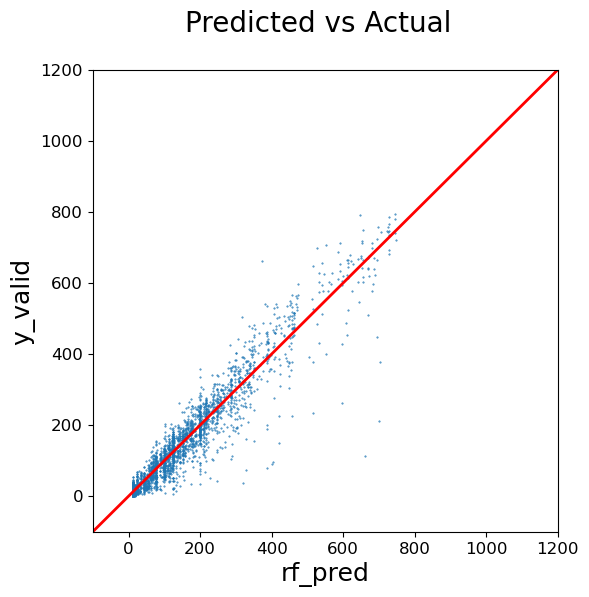

In [54]:
plt.figure(figsize=(6,6))
plt.scatter(rf_pred_reg, y_valid_reg, s = 0.2)
plt.xlim(-100, 1200)
plt.ylim(-100, 1200)
plt.plot([-100, 1200], [-100, 1200], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('rf_pred', fontsize=18)
plt.ylabel('y_valid', fontsize=18)
plt.show()

What is the accuracy of the model?

In [55]:
rf_pred = rf_pred_cas + rf_pred_reg
accuracy(y_valid, rf_pred)

RMSE,MAE,R^2,RMSLE
56.782440,36.865976,0.900820,0.594043


# Fit a boosted trees model

A boosted tree iteratively fits trees where each tree tries to correct the errors of all of the previous trees (summed together). This is a very powerful machine learning technique. Boosted trees have some of the same parameters as regression trees, but sometimes the names are a little different. The paramaters that you are most likely to want to tune are:
  * `n_estimators`: This is the number of trees used for the final model. The more trees, the more likely the model is to overfit.
  * `learning_rate`: This is a parameter that determines how much weight is given to each tree (this is sometimes referred to as $\lambda$, pronounced lambda). The larger this number, the more likely the model is to overfit.
  * `max_depth`: This is the same as `max_depth` for a regression tree.
  * `min_split_loss`: This is the same as `min_impurity_decrease` for a regression tree.

Other good references are available at https://xgboost.readthedocs.io/en/latest/index.html, https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn, and https://xgboost.readthedocs.io/en/latest/tutorials/model.html.

<img src="images/gradient-boosted-regression-trees-632x238.png" width="800"/>

In [148]:
#param_rand  = {'n_estimators': [400, 500, 600],
 #             'max_features': [3, 4, 5],
  #            'min_samples_leaf': [5, 6, 7]}

#xgb_model_reg = GridSearchCV(XGBRegressor(ccp_alpha=10, random_state=201), param_grid=param_rand, cv=4, n_jobs=num_cpus)

xgb_model_reg = XGBRegressor(max_depth=9,
                         n_estimators = 55,
                         learning_rate=.095,
                         random_state=201)
xgb_model_reg.fit(X_train_reg, y_train_reg)
xgb_pred_reg = xgb_model_reg.predict(X_valid_reg)
accuracy(y_valid_reg, xgb_pred_reg)

RMSE,MAE,R^2,RMSLE
34.698193,19.765194,0.946464,0.325256


In [147]:
xgb_model_cas = XGBRegressor(max_depth=9,
                         n_estimators = 50,
                         learning_rate=.1,
                         random_state=201)
xgb_model_cas.fit(X_train_cas, y_train_cas)
xgb_pred_cas = xgb_model_cas.predict(X_valid_cas)
accuracy(y_valid_cas, xgb_pred_cas)

RMSE,MAE,R^2,RMSLE
19.066554,10.723814,0.852785,0.573028


Get the unnormalized feature importance scores.

In [129]:
get_tree_importances(xgb_model_reg, X_train_reg)

,Importance
hour,0.325429
workingday,0.287483
year,0.276042
month,0.042990
weather,0.027563
DOW,0.020242
atemp,0.016164
holiday,0.004087


In [130]:
get_tree_importances(xgb_model_cas, X_train_cas)

,Importance
workingday,0.566356
hour,0.190706
atemp,0.123237
DOW,0.051591
weather,0.027207
humidity,0.024190
windspeed,0.014462
holiday,0.002251


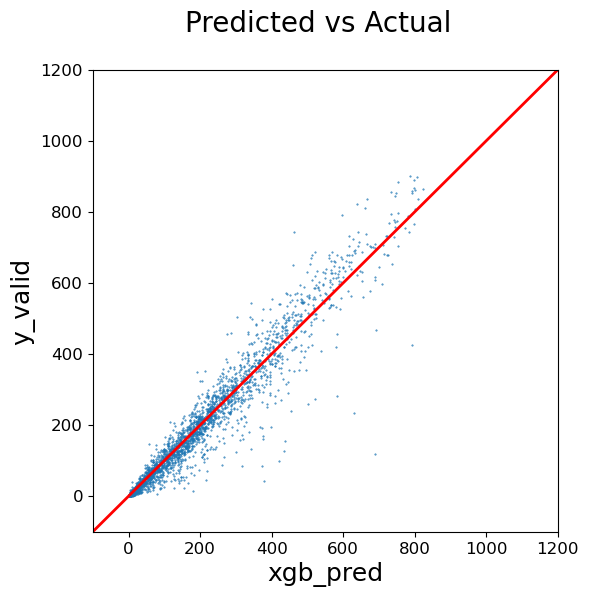

In [131]:
plt.figure(figsize=(6,6))
plt.scatter(xgb_pred, y_valid, s = 0.2)
plt.xlim(-100, 1200)
plt.ylim(-100, 1200)
plt.plot([-100, 1200], [-100, 1200], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('xgb_pred', fontsize=18)
plt.ylabel('y_valid', fontsize=18)
plt.show()

What is the accuracy of the boosted tree?

In [133]:
#accuracy(y_valid, xgb_pred)

xgb_pred = xgb_pred_cas + xgb_pred_reg
accuracy(y_valid, xgb_pred)

RMSE,MAE,R^2,RMSLE
42.611538,25.115194,0.944146,0.328938


## Advanced Topic - Saving Your Model for Later

Particularly when you have spent a long time searching for the optimal parameters, it can be computationally prohibitive to need to re-run the model everytime that you want to use the model. This is especially true when you may want to train a few different models in order to ensemble them. In order to avoid having to retrain the models, we can save the models for later. In python, this is called "pickling". We use a package called `dill` to "pickle" things in python (programmers tend to be a little cheeky). We can pickle the `rt_model_retrain` that we fitted above using the below code.

In [ ]:
with open("rt_model_retrain_pickled.pkl", 'wb') as f:
    dill.dump(rt_model_retrain, f)

Now anytime that we want to use the model again, we can just load it from the file (assuming we've already imported pickle) using the below code.

In [ ]:
with open("rt_model_retrain_pickled.pkl", 'rb') as f:
    rt_model_reloaded = dill.load(f)

The `with open("rt_model_retrain_pickled.pkl", 'rb') as f:` code just means that we want python to read (that's the `r`) a binary file (a file with just `0`s and `1`s, which is indicated by the `b`) called `"rt_model_retrain_pickled.pkl"` and we'll refer to that file as `f`. The `with` part just means to only keep the file open while we run the indented piece of code, and then to close the file. When we are pickling instead of reading, we use a `w` instead of `r` to indicate that we want to write instead of read.

We can then check and make sure it worked by trying to predict on the validation data after loading in the model.

In [ ]:
rt_model_reloaded.predict(X_valid)

In [ ]:
rt_model_retrain.predict(X_valid)

Since both gives us the same thing, we succesfully pickled and loaded the model from a file. You may not ever need to use this for this class, but it is a trick that is good to know in case you find yourself training a model that takes a really long time and you'd like to avoid having to retrain it.

## Make predictions in the testing set

In [ ]:
#prediction accuracy check for all models consolidated here
#random forest
accuracy(y_valid, rf_pred)
#boosted trees
accuracy(y_valid, xgb_pred)
#ensembled model
ens_pred = (rf_pred + xgb_pred) / 2
accuracy(y_valid, ens_pred)

Once you have chosen a model (including determining which parameters to use for the model) or models (in the case you intend to ensemble different models), it is time to retrain the model on the original training set. This allows you to use all of the data possible to build the best model. Note that you should do this after you have chosen your parameters using the validation set. For this block of code, I'm going to assume that you are going to go with the boosted trees model (parameters `max_depth=6, n_estimators = 50, learning_rate=.1`) we trained above ensembled with the regression tree model we tuned with `GridSearchCV` (optimal parameters found were `max_features=.5, max_depth=15, min_impurity_decrease=0.01, min_samples_split=10`). First, we will train models with those parameters, and then we will predict on the test data.

In [134]:
xgb_model_reg_final = XGBRegressor(max_depth=9,
                         n_estimators = 55,
                         learning_rate=.095,
                         random_state=201)

xgb_model_reg_final.fit(X_orig_train_reg, y_orig_train_reg)

xgb_model_cas_final = XGBRegressor(max_depth=9,
                         n_estimators = 50,
                         learning_rate=.095,
                         random_state=201)

xgb_model_cas_final.fit(X_orig_train_cas, y_orig_train_cas)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.095, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=201, ...)

Now we can predict on the testing set.

In [135]:
xgb_final_pred_reg = xgb_model_reg_final.predict(X_test_reg)
xgb_final_pred_cas = xgb_model_cas_final.predict(X_test_cas)

Once we have our predictions we can ensemble them. There are lots of ways to do this, but if we just want to average the two models, it is enough to just add the predictions together and divide by 2 (since this is all an average is). Before we average them, we'll make sure that our predictions are above 0 by clipping them with the `.clip()` method. If we accidentally predict something below 0, it can mess up the RMSLE (since you can't put a negative number into a log function). All clip does is it takes any number in the series below 0 and sets it to 0. Since we are predicting counts of bike riders, obviously negative numbers don't make sense. So, this is good practice when making final predictions when you are going to be evaluated on RMSLE.

In [136]:
final_pred = xgb_final_pred_reg.clip(0) + xgb_final_pred_cas.clip(0)

# Competition entries (write to csv)

Finally, we need to prepare the Kaggle submission in the right format. We first read in the `sampleSubmission.csv` which we downloaded from Kaggle.

In [137]:
sample_submission = pd.read_csv('sampleSubmission.csv')

In [138]:
sample_submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


Note that the counts are all `0`. We will replace them with our predictions.

In [139]:
sample_submission['count'] = final_pred

We can see that it worked.

In [140]:
sample_submission.head()

,datetime,count
0,2011-01-20 00:00:00,13.092834
1,2011-01-20 01:00:00,7.934250
2,2011-01-20 02:00:00,3.855698
3,2011-01-20 03:00:00,3.863078
4,2011-01-20 04:00:00,3.748399


Now we will write these out to a csv file in the format that Kaggle expects. Note that if you open the submission file in excel and then save it, excel will mess something up and Kaggle will not accept the submission. If you open your submission file in excel to check what's in there, just be sure not to save it afterwards.

In [141]:
sample_submission.to_csv('finalSubmission.csv', index=False)

Now that the competition has ended, it will not give you your rank on the leaderboard, but it will give you your score. Look through the leaderboard to find where you score would have ranked. Come to class with your rank on the Kaggle leaderboard!